In [1]:
from utils import load_images_glob

train_benign = load_images_glob("data/train/Benign")
train_malignant = load_images_glob("data/train/Malignant")
test_benign = load_images_glob("data/test/Benign")
test_malignant = load_images_glob("data/test/Malignant")

print("Train benign:", len(train_benign))
print("Train malignant:", len(train_malignant))
print("Test benign:", len(test_benign))
print("Test malignant:", len(test_malignant))

100%|██████████| 1000/1000 [00:03<00:00, 257.85it/s]

Train benign: 6289
Train malignant: 5590
Test benign: 1000
Test malignant: 1000


# Calculate the Mean and Std of the dataset

In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from dataset import CancerDataset

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CancerDataset(root_dir='data', split='train', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=2)

mean = 0.0
std = 0.0
nb_samples = 0

# Iterate over the DataLoader
for images, _ in train_loader:
    # images shape: [batch_size, channels, height, width]
    batch_samples = images.size(0)  # number of samples in the batch
    images = images.view(batch_samples, images.size(1), -1)  # flatten H and W into one dimension

    # Compute mean and std per channel for the batch
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples

# Final average over all batches
mean /= nb_samples
std /= nb_samples

print('Mean:', mean)
print('Std:', std)

Mean: tensor([0.7230, 0.5556, 0.5390])
Std: tensor([0.1209, 0.1340, 0.1448])


# PCA + SVM

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset import CancerDataset

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

transform_svm = transforms.Compose([
    transforms.Resize((32, 32)),   
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7230, 0.5556, 0.5390], std=[0.1209, 0.1340, 0.1448])        
])

train_dataset = CancerDataset(root_dir="data", split="train", transform=transform_svm)
test_dataset  = CancerDataset(root_dir="data", split="test", transform=transform_svm)

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

X_train = train_images.view(train_images.shape[0], -1).numpy()
y_train = train_labels.numpy()

X_test = test_images.view(test_images.shape[0], -1).numpy()
y_test = test_labels.numpy()

pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

svm = SVC(kernel='linear')
svm.fit(X_train_pca, y_train)

y_pred = svm.predict(X_test_pca)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Test Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Test Recall:", recall_score(y_test, y_pred, average='weighted'))

Test Accuracy: 0.801
Test F1 Score: 0.8004810512142082
Test Precision: 0.8041645277466765
Test Recall: 0.801


# Resnext


In [3]:
import torch
import torchvision
import torch.nn as nn

test_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.7230, 0.5556, 0.5390], std=[0.1209, 0.1340, 0.1448])
    ])

test_dataset  = CancerDataset(root_dir="data", split="test", transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from utils import get_model
from train import evaluation

resnext_model = get_model("resnext").to(device)
resnext_model.load_state_dict(torch.load("checkpoints/resnext.pth"))
test_loss, (resnext_test_acc, resnext_f1, resnext_precision, resnext_recall) = evaluation(resnext_model, test_loader, criterion)


print("Test Accuracy:", resnext_test_acc)
print("Test F1 Score:", resnext_f1)
print("Test Precision:", resnext_precision)
print("Test Recall:", resnext_recall)

Test Accuracy: 96.7
Test F1 Score: 0.9669973267834695
Test Precision: 0.9671513570396808
Test Recall: 0.967


# EfficientNet

In [12]:
efficientnet_model = get_model("efficientnet").to(device)
efficientnet_model.load_state_dict(torch.load("checkpoints/efficientnet.pth"))
test_loss, (efficientnet_test_acc, efficientnet_f1, efficientnet_precision, efficientnet_recall) = evaluation(efficientnet_model, test_loader, criterion)


print("Test Accuracy:", efficientnet_test_acc)
print("Test F1 Score:", efficientnet_f1)
print("Test Precision:", efficientnet_precision)
print("Test Recall:", efficientnet_recall)

Test Accuracy: 96.7
Test F1 Score: 0.966999702997327
Test Precision: 0.9670168126052539
Test Recall: 0.967


# Swin Transformer

In [13]:
swin_model = get_model("swin").to(device)
swin_model.load_state_dict(torch.load("checkpoints/swin.pth"))
test_loss, (swin_test_acc, swin_f1, swin_precision, swin_recall) = evaluation(swin_model, test_loader, criterion)


print("Test Accuracy:", swin_test_acc)
print("Test F1 Score:", swin_f1)
print("Test Precision:", swin_precision)
print("Test Recall:", swin_recall)

Test Accuracy: 96.45
Test F1 Score: 0.9644995651196727
Test Precision: 0.9645227616153191
Test Recall: 0.9644999999999999


# Convnext

In [14]:
convnext_model = get_model("convnext").to(device)
convnext_model.load_state_dict(torch.load("checkpoints/convnext.pth"))
test_loss, (convnext_test_acc, convnext_f1, convnext_precision, convnext_recall) = evaluation(convnext_model, test_loader, criterion)


print("Test Accuracy:", convnext_test_acc)
print("Test F1 Score:", convnext_f1)
print("Test Precision:", convnext_precision)
print("Test Recall:", convnext_recall)

Test Accuracy: 97.05
Test F1 Score: 0.9704999336248507
Test Precision: 0.9705042345381107
Test Recall: 0.9704999999999999


# Ensemble

In [34]:
from tqdm import tqdm

def ensemble_evaluation(models, test_loader, criterion):
    # Put all models in evaluation mode
    for model in models:
        model.eval()
        
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Lists to store true labels and predictions for metrics computation
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating Ensemble", unit="batch", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            # Initialize ensemble outputs to zero
            ensemble_outputs = None
            
            # Sum outputs from each model
            for model in models:
                outputs = model(images)
                if ensemble_outputs is None:
                    ensemble_outputs = outputs
                else:
                    ensemble_outputs += outputs
            
            # Average the outputs across the ensemble
            ensemble_outputs /= len(models)
            
            # Compute loss using the averaged outputs
            loss = criterion(ensemble_outputs, labels)
            running_loss += loss.item() * images.size(0)
            
            # Get predictions from ensemble outputs
            _, predicted = torch.max(ensemble_outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions and labels (moving to CPU for metric computations)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate evaluation metrics
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    
    return epoch_loss, (epoch_acc, f1, precision, recall)

In [37]:
ensemble_model = [resnext_model, efficientnet_model, swin_model, convnext_model]
test_loss, (ensemble_test_acc, ensemble_f1, ensemble_precision, ensemble_recall) = ensemble_evaluation(ensemble_model, test_loader, criterion)

print("Test Accuracy:", ensemble_test_acc)
print("Test F1 Score:", ensemble_f1)
print('Test Precision:', ensemble_precision)
print('Test Recall:', ensemble_recall)

Test Accuracy: 96.9
Test F1 Score: 0.9689992249806245
Test Precision: 0.9690469046904691
Test Recall: 0.969


# Results

| Model         | Accuracy | F1 Score | Precision | Recall |
|---------------|---------:|---------:|----------:|-------:|
| **SVM**       |    80.100 |     0.800 |     0.804 |  0.801 |
| **ResNeXt**   |   96.700 |     0.967 |     0.967 |  0.967 |
| **EfficientNet** |   96.700 |     0.967 |     0.967 |  0.967 |
| **Swin**      |   96.450 |     0.964 |     0.965 |  0.964 |
| **ConvNeXt**  |   97.050 |     0.970 |     0.971 |  0.970 |
| **Ensemble**  |   96.900 |      0.968|    0.969  |   0.969|



**Ensemble** Includes ResNeXt, EfficientNet, Swin,ConvNeXt

# T-sne

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def generate_tsne(model, test_loader):
    model.eval()
    features = []
    labels = []
    # Get device from model parameters
    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            output = output.view(output.size(0), -1)
            features.append(output.cpu().numpy())
            labels.append(targets.cpu().numpy())

    # Concatenate features and labels from all batches
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Apply t-SNE to reduce the feature dimensions to 2
    tsne = TSNE(n_components=2)
    features_tsne = tsne.fit_transform(features)

    # Plot the t-SNE result
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title("t-SNE of ConvNeXt Features")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()
    

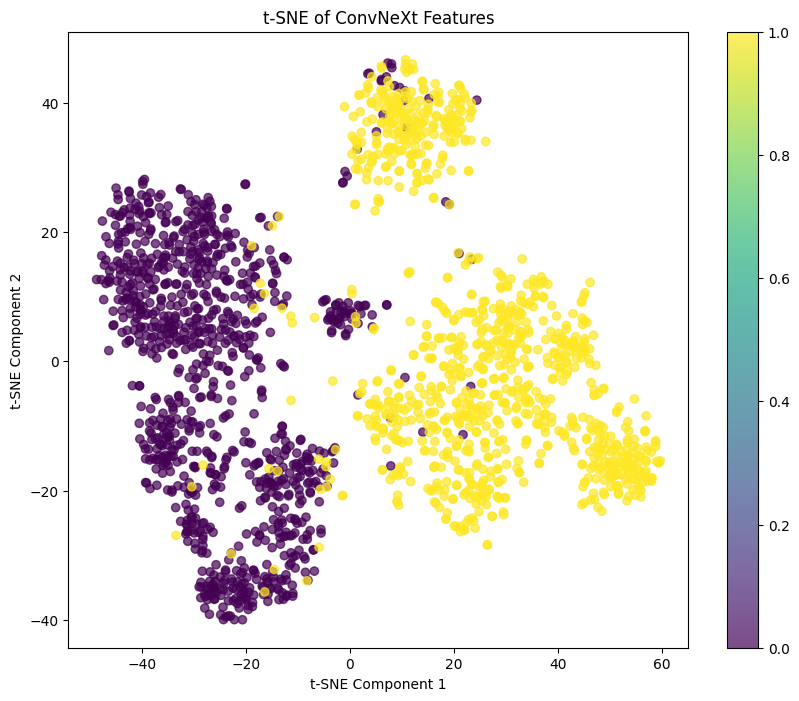

In [56]:
convnext_model_tsne = get_model("convnext").to(device)
convnext_model_tsne.load_state_dict(torch.load("checkpoints/convnext.pth"))
convnext_model_tsne.eval()
convnext_model_tsne.classifier[2] = nn.Identity()

generate_tsne(convnext_model_tsne, test_loader)

# ROC AUC score and ROC curve

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

def compute_roc_auc(model, data_loader, device):
    model.eval()
    all_targets = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Get logits from the model (shape: [batch_size, 2])
            outputs = model(inputs)
            
            # Convert logits to probabilities using softmax over the class dimension
            probs = torch.softmax(outputs, dim=1)
            
            # Select the probability for the positive class (index 1)
            positive_probs = probs[:, 1]
            
            # Collect the targets and predictions
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(positive_probs.cpu().numpy())
    
    all_targets = np.array(all_targets)
    all_preds = np.array(all_preds)
    
    roc_auc = roc_auc_score(all_targets, all_preds)
    return roc_auc

def plot_roc_curve(model, data_loader, device):
    model.eval()
    all_targets = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Get logits from the model (output shape: [batch_size, 2])
            outputs = model(inputs)
            
            # Convert logits to probabilities using softmax over the class dimension
            probs = torch.softmax(outputs, dim=1)
            
            # Select the probability for the positive class (index 1)
            positive_probs = probs[:, 1]
            
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(positive_probs.cpu().numpy())
    
    # Convert lists to numpy arrays
    all_targets = np.array(all_targets)
    all_preds = np.array(all_preds)
    
    # Compute the ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(all_targets, all_preds)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

In [15]:
roc_auc = compute_roc_auc(resnext_model, test_loader, device)
print("ResNext ROC AUC:", roc_auc)
roc_auc = compute_roc_auc(efficientnet_model, test_loader, device)
print("EfficientNet ROC AUC:", roc_auc)
roc_auc = compute_roc_auc(swin_model, test_loader, device)
print("Swin ROC AUC:", roc_auc)
roc_auc = compute_roc_auc(convnext_model, test_loader, device)
print("ConvNext ROC AUC:", roc_auc)


ResNext ROC AUC: 0.99253
EfficientNet ROC AUC: 0.993271
Swin ROC AUC: 0.992421
ConvNext ROC AUC: 0.9928025


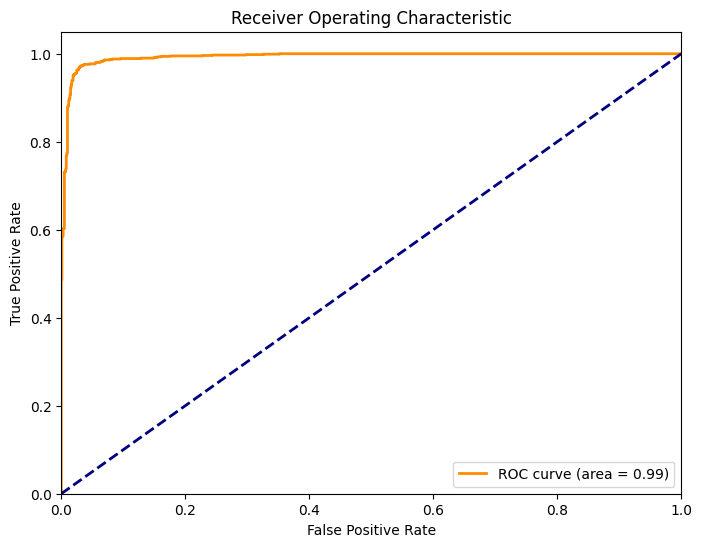

np.float64(0.9928025)

In [11]:
plot_roc_curve(convnext_model, test_loader, device)